Installing transformers library

In [ ]:
!pip install transformers

*Split-sentence*

In [ ]:
#this function takes a sentence as an argumente and returns the tokens or words by splitting the sentence using space and comma.
def splitSentence(sentence):
  split_sentence = sentence.split(",") # split by commas
  split_sentence = [word.split() for word in split_sentence] # split each word by space
  split_sentence = [word for sublist in split_sentence for word in sublist] # flatten the list of lists

  return split_sentence

Importing the necesssary libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
from sklearn.preprocessing import OneHotEncoder
import torch
from transformers import BertTokenizer, BertModel


In [ ]:
df = pd.read_csv("Restaurants_Train_v2.csv")
df.head()


,id,Sentence,Aspect Term,polarity,from,to
0,3121,But the staff was so horrible to us.,staff,negative,8,13
1,2777,"To be completely fair, the only redeeming fact...",food,positive,57,61
2,1634,"The food is uniformly exceptional, with a very...",food,positive,4,8
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,55,62
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,141,145


In [ ]:
df = df.drop('id',axis=1)
df = df.drop('from',axis=1)
df = df.drop('to',axis=1)

df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"The food is uniformly exceptional, with a very...",food,positive
3,"The food is uniformly exceptional, with a very...",kitchen,positive
4,"The food is uniformly exceptional, with a very...",menu,neutral
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,neutral
3689,Each table has a pot of boiling water sunken i...,meats,neutral
3690,Each table has a pot of boiling water sunken i...,vegetables,neutral
3691,Each table has a pot of boiling water sunken i...,rice,neutral


In [ ]:
def map_to_int(x):
    if x=='positive':
        return 1
    elif x=='negative':
        return 2
    else:
        return 0
df['polarity'] = df['polarity'].apply(map_to_int)
df

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,2
1,"To be completely fair, the only redeeming fact...",food,1
2,"The food is uniformly exceptional, with a very...",food,1
3,"The food is uniformly exceptional, with a very...",kitchen,1
4,"The food is uniformly exceptional, with a very...",menu,0
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,0
3689,Each table has a pot of boiling water sunken i...,meats,0
3690,Each table has a pot of boiling water sunken i...,vegetables,0
3691,Each table has a pot of boiling water sunken i...,rice,0


**In-domain vectors**

In [ ]:

!pip install gensim
!pip install --upgrade numpy


In [ ]:
import gensim
import pandas as pd
import numpy as np

# Step 1: Load the restaurant-related text dataset
restaurant_data = df
# Step 2: Preprocess the data
processed_data = restaurant_data['Sentence'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Step 3: Train the FastText model
model1 = gensim.models.FastText(processed_data, size=100, window=5, min_count=1, workers=4, sg=1)

def indomain_vector(text):
    # Step 4: Generate the embeddings
    embeddings = []
    for word in splitSentence(text):
        try:
            embeddings.append(model1.wv.get_vector(word))
        except KeyError:
            embeddings.append(np.zeros(100))

    # Example: Print the embeddings for each word
    return torch.tensor(embeddings)



*BERT-TOKENS*

In [ ]:
model2 = BertModel.from_pretrained('bert-base-uncased')

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
def bert_to_token(sentence):
   

  # Define the sentence to be tokenized

  # Tokenize the sentence
  tokens = splitSentence(sentence)
  # print(len(tokens))
  # Convert tokens to ids
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  # print(len(input_ids))
  # Add special tokens
  # Convert input_ids to tensor
  input_ids = torch.tensor(input_ids).unsqueeze(0)
  # print(len(input_ids))
  # Get the 768 dimensional vectors for each token
  outputs = model2(input_ids)
  # print(outputs,len(outputs))
  token_vectors = outputs.last_hidden_state.squeeze(0)
  return token_vectors

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


*BERT+In-domain*

In [ ]:
# sentences = []
# for i in range(2800):
#   sentence = df['Sentence'][i]
#   ten1 = np.array(indomain_vector(sentence))
#   ten2 = bert_to_token(sentence).detach().numpy()
#   vec = np.concatenate((ten1, ten2), axis=1)
#   sentences.append(vec)
def create_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        ten1 = indomain_vector(sentence)
        ten2 = bert_to_token(sentence).detach()
        vec = torch.cat([ten1, ten2], dim=1).numpy()
        embeddings.append(vec)

    embeddings_array = np.array(embeddings)
    return torch.from_numpy(embeddings_array)
  
sentences = []
for i in range(2800):
    sentence = df['Sentence'][i]
    embeddings = create_embeddings([sentence])
    sentences.append(np.array(embeddings[0]))

In [ ]:
# sentence = df['Sentence'][0]
# ten1 = np.array(indomain_vector(sentence))
# ten2 = bert_to_token(sentence).detach().numpy()
# vec = np.concatenate((ten1, ten2), axis=1)
# print(vec)

*padding sentences for making input length as same*

In [ ]:
# Calculate the maximum length of sentences
max_length = max(len(s) for s in sentences)

# Pad each sentence to the maximum length
padded_sentences = np.zeros((len(sentences), max_length, 868))
for i, s in enumerate(sentences):
    padded_sentences[i, :len(s), :] = s





In [ ]:
label = np.array(df['polarity'])

# LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc(last_hidden_state)
        return out

# Define the input sentences and labels
sentences1 = padded_sentences
labels = label[:2800]

# Convert the labels to one-hot encoding
one_hot_labels = np.zeros((len(labels), 3))
for i in range(len(labels)):
    one_hot_labels[i, labels[i]] = 1

# Convert the input sentences to PyTorch tensors
sentences1 = torch.tensor(sentences1, dtype=torch.float32)
one_hot_labels = torch.tensor(one_hot_labels, dtype=torch.float32)

# Define the hyperparameters
input_size = 868
hidden_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Initialize the model and optimizer
model = LSTMClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i in range(0, len(sentences1), batch_size):
        batch_sentences = sentences1[i:i+batch_size]
        batch_labels = torch.argmax(one_hot_labels[i:i+batch_size], dim=1)
        optimizer.zero_grad()
        outputs = model(batch_sentences)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(model.state_dict(), 'lstm.pt')

Epoch [1/100], Loss: 0.9891
Epoch [2/100], Loss: 1.0024
Epoch [3/100], Loss: 1.0228
Epoch [4/100], Loss: 1.0366
Epoch [5/100], Loss: 1.0424
Epoch [6/100], Loss: 1.0451
Epoch [7/100], Loss: 1.0469
Epoch [8/100], Loss: 1.0486
Epoch [9/100], Loss: 1.0500
Epoch [10/100], Loss: 1.0512
Epoch [11/100], Loss: 1.0522
Epoch [12/100], Loss: 1.0530
Epoch [13/100], Loss: 1.0534
Epoch [14/100], Loss: 1.0538
Epoch [15/100], Loss: 1.0537
Epoch [16/100], Loss: 1.0539
Epoch [17/100], Loss: 1.0538
Epoch [18/100], Loss: 1.0536
Epoch [19/100], Loss: 1.0529
Epoch [20/100], Loss: 1.0529
Epoch [21/100], Loss: 1.0529
Epoch [22/100], Loss: 1.0529
Epoch [23/100], Loss: 1.0526
Epoch [24/100], Loss: 1.0530
Epoch [25/100], Loss: 1.0527
Epoch [26/100], Loss: 1.0531
Epoch [27/100], Loss: 1.0532
Epoch [28/100], Loss: 1.0535
Epoch [29/100], Loss: 1.0533
Epoch [30/100], Loss: 1.0537
Epoch [31/100], Loss: 1.0538
Epoch [32/100], Loss: 1.0539
Epoch [33/100], Loss: 1.0531
Epoch [34/100], Loss: 1.0534
Epoch [35/100], Loss: 1

*Prediction*

In [ ]:
def predicted(sen):
  # sen = df['Sentence'][1]
    t1 = np.array(indomain_vector(sen))
    t2 = bert_to_token(sen).detach().numpy()
    v = np.concatenate((t1, t2), axis=1)
    test_sentence = v
    padded_sentence = np.zeros((1, max_length, 868))
    padded_sentence[0, :len(test_sentence), :] = test_sentence

    # Convert the padded sentence to a PyTorch tensor
    padded_sentence = torch.tensor(padded_sentence, dtype=torch.float32)

    # Pass the padded sentence through the trained model to get the predicted class
    with torch.no_grad():
        output = model(padded_sentence)
        predicted_class = torch.argmax(output).item()

    # Print the predicted class
    return predicted_class

In [ ]:
s = df['Sentence']
predict = []
count = 0
for i in range(2800,3600):
  p =predicted(s[i])
  if p!=df['polarity'][i]:
    count = count + 1

In [ ]:
print("accuracy=",(800-count)*100/800,"%")

accuracy= 62.625 %


# TD-LSTM

In [ ]:
#finding start and end index of aspect_term in sentence. example: sentence=['the','fried','rice,'is','good'] , aspect_term=['fried','rice']. Then function returns [1,2] . 
def ind(sentence,aspect_term):
    sentence = splitSentence(sentence)
    aspect_term = splitSentence(aspect_term)
    try:
        start_index = sentence.index(aspect_term[0])
        end_index = start_index + len(aspect_term) - 1
    except ValueError:
        start_index = len(sentence) - 1
        end_index = start_index -1
    return [start_index,end_index]

#this below code gives start and end index of aspect_term in sentence for all sentences.
indices = []
s = df['Sentence']
a = df['Aspect Term']
for i in range(len(s)):
    indices.append(ind(s[i],a[i]))

In [ ]:
#this code will return 2d-array consists of tokens for left of aspect terms and tokens of 868d vectors for right of aspect terms in sentence.
def pair(i):
    s1 = np.array(sentences[i])
    answer = []
    i1 = indices[i][0]
    j1 = indices[i][1]
    answer.append(s1[:i1+1])
    answer.append(s1[j1-1:])
    return answer
# for all sentences splitting left aspect terms and right aspect terms
input_pairs = []
for i in range(len(sentences)):
    input_pairs.append(pair(i))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TDLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TDLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # Concatenate output from both LSTMs
    
    def forward(self, x1,x2):
        lstm_out1, _ = self.lstm1(x1)
        lstm_out2, _ = self.lstm2(x2)
        lstm_out = torch.cat((lstm_out1[:, -1, :], lstm_out2[:, -1, :]), dim=1)  # Concatenate output from both LSTMs
        out = self.fc(lstm_out)
        return out
input_size = 868
hidden_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 1

# Initialize the model and optimizer
tdmodel = TDLSTMClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tcmodel.parameters(), lr=learning_rate)

# assuming you have your data in the form of input pairs and labels:
# input_pairs is a list of pairs of input sequences (x1, x2)
# labels is a list of corresponding labels

for epoch in range(num_epochs):
    for i in range(len(input_pairs[:2800])):
        # get the current input pair and label
        x1, x2 = input_pairs[i][0] , input_pairs[i][1]
        label1 = label[i]
        
        # convert input and label to PyTorch tensors
        label1 = torch.LongTensor([label1])
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass through the model
        output = tcmodel(torch.FloatTensor(x1).unsqueeze(0), torch.FloatTensor(x2).unsqueeze(0))
        
        # calculate the loss and backpropagate
        loss = criterion(output, label1)
        loss.backward()
        
        # update the model parameters
        optimizer.step()
        
        # print the loss every 100 steps
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(input_pairs), loss.item()))

torch.save(tcmodel.state_dict(), 'td-lstm.pt')

Epoch [1/100], Step [100/3600], Loss: 0.2925
Epoch [1/100], Step [200/3600], Loss: 0.2353
Epoch [1/100], Step [300/3600], Loss: 0.7469
Epoch [1/100], Step [400/3600], Loss: 1.5018
Epoch [1/100], Step [500/3600], Loss: 1.1529
Epoch [1/100], Step [600/3600], Loss: 0.1134
Epoch [1/100], Step [700/3600], Loss: 0.3605
Epoch [1/100], Step [800/3600], Loss: 0.3439
Epoch [1/100], Step [900/3600], Loss: 0.3373
Epoch [1/100], Step [1000/3600], Loss: 0.8123
Epoch [1/100], Step [1100/3600], Loss: 0.3549
Epoch [1/100], Step [1200/3600], Loss: 0.5038
Epoch [1/100], Step [1300/3600], Loss: 0.7802
Epoch [1/100], Step [1400/3600], Loss: 0.3669
Epoch [1/100], Step [1500/3600], Loss: 1.4596
Epoch [1/100], Step [1600/3600], Loss: 1.6686
Epoch [1/100], Step [1700/3600], Loss: 1.0733
Epoch [1/100], Step [1800/3600], Loss: 0.3146
Epoch [1/100], Step [1900/3600], Loss: 0.3141
Epoch [1/100], Step [2000/3600], Loss: 0.1974
Epoch [1/100], Step [2100/3600], Loss: 1.2755
Epoch [1/100], Step [2200/3600], Loss: 0.95

Epoch [7/100], Step [1300/3600], Loss: 0.0244
Epoch [7/100], Step [1400/3600], Loss: 0.1594
Epoch [7/100], Step [1500/3600], Loss: 0.2198
Epoch [7/100], Step [1600/3600], Loss: 0.1145
Epoch [7/100], Step [1700/3600], Loss: 0.0363
Epoch [7/100], Step [1800/3600], Loss: 0.0407
Epoch [7/100], Step [1900/3600], Loss: 0.1389
Epoch [7/100], Step [2000/3600], Loss: 0.0156
Epoch [7/100], Step [2100/3600], Loss: 0.0122
Epoch [7/100], Step [2200/3600], Loss: 0.3685
Epoch [7/100], Step [2300/3600], Loss: 0.0400
Epoch [7/100], Step [2400/3600], Loss: 0.0364
Epoch [7/100], Step [2500/3600], Loss: 0.1301
Epoch [7/100], Step [2600/3600], Loss: 0.3093
Epoch [7/100], Step [2700/3600], Loss: 0.2365
Epoch [7/100], Step [2800/3600], Loss: 0.4716
Epoch [8/100], Step [100/3600], Loss: 0.0016
Epoch [8/100], Step [200/3600], Loss: 0.1126
Epoch [8/100], Step [300/3600], Loss: 0.1608
Epoch [8/100], Step [400/3600], Loss: 0.1506
Epoch [8/100], Step [500/3600], Loss: 0.1227
Epoch [8/100], Step [600/3600], Loss: 0

Epoch [13/100], Step [2200/3600], Loss: 0.2465
Epoch [13/100], Step [2300/3600], Loss: 0.3589
Epoch [13/100], Step [2400/3600], Loss: 0.0049
Epoch [13/100], Step [2500/3600], Loss: 0.0007
Epoch [13/100], Step [2600/3600], Loss: 0.2163
Epoch [13/100], Step [2700/3600], Loss: 0.0001
Epoch [13/100], Step [2800/3600], Loss: 0.2403
Epoch [14/100], Step [100/3600], Loss: 0.0184
Epoch [14/100], Step [200/3600], Loss: 0.0060
Epoch [14/100], Step [300/3600], Loss: 0.0912
Epoch [14/100], Step [400/3600], Loss: 0.0382
Epoch [14/100], Step [500/3600], Loss: 0.0518
Epoch [14/100], Step [600/3600], Loss: 0.0000
Epoch [14/100], Step [700/3600], Loss: 0.0076
Epoch [14/100], Step [800/3600], Loss: 0.0008
Epoch [14/100], Step [900/3600], Loss: 0.0026
Epoch [14/100], Step [1000/3600], Loss: 0.0017
Epoch [14/100], Step [1100/3600], Loss: 0.1365
Epoch [14/100], Step [1200/3600], Loss: 0.1230
Epoch [14/100], Step [1300/3600], Loss: 0.0050
Epoch [14/100], Step [1400/3600], Loss: 0.4479
Epoch [14/100], Step [

Epoch [20/100], Step [200/3600], Loss: 0.0046
Epoch [20/100], Step [300/3600], Loss: 0.0022
Epoch [20/100], Step [400/3600], Loss: 0.0019
Epoch [20/100], Step [500/3600], Loss: 0.0214
Epoch [20/100], Step [600/3600], Loss: 0.0000
Epoch [20/100], Step [700/3600], Loss: 0.0025
Epoch [20/100], Step [800/3600], Loss: 0.0052
Epoch [20/100], Step [900/3600], Loss: 0.0004
Epoch [20/100], Step [1000/3600], Loss: 0.0003
Epoch [20/100], Step [1100/3600], Loss: 0.0008
Epoch [20/100], Step [1200/3600], Loss: 0.0007
Epoch [20/100], Step [1300/3600], Loss: 0.0001
Epoch [20/100], Step [1400/3600], Loss: 0.1294
Epoch [20/100], Step [1500/3600], Loss: 0.0090
Epoch [20/100], Step [1600/3600], Loss: 0.0003
Epoch [20/100], Step [1700/3600], Loss: 0.0248
Epoch [20/100], Step [1800/3600], Loss: 0.0001
Epoch [20/100], Step [1900/3600], Loss: 0.0092
Epoch [20/100], Step [2000/3600], Loss: 0.0000
Epoch [20/100], Step [2100/3600], Loss: 0.0402
Epoch [20/100], Step [2200/3600], Loss: 0.0054
Epoch [20/100], Step 

Epoch [26/100], Step [1000/3600], Loss: 0.0064
Epoch [26/100], Step [1100/3600], Loss: 0.0003
Epoch [26/100], Step [1200/3600], Loss: 0.0013
Epoch [26/100], Step [1300/3600], Loss: 0.0003
Epoch [26/100], Step [1400/3600], Loss: 0.0115
Epoch [26/100], Step [1500/3600], Loss: 0.0003
Epoch [26/100], Step [1600/3600], Loss: 0.0011
Epoch [26/100], Step [1700/3600], Loss: 0.0003
Epoch [26/100], Step [1800/3600], Loss: 0.0006
Epoch [26/100], Step [1900/3600], Loss: 0.0066
Epoch [26/100], Step [2000/3600], Loss: 0.0000
Epoch [26/100], Step [2100/3600], Loss: 0.0002
Epoch [26/100], Step [2200/3600], Loss: 0.0044
Epoch [26/100], Step [2300/3600], Loss: 0.0089
Epoch [26/100], Step [2400/3600], Loss: 0.0006
Epoch [26/100], Step [2500/3600], Loss: 0.0458
Epoch [26/100], Step [2600/3600], Loss: 0.0045
Epoch [26/100], Step [2700/3600], Loss: 0.0518
Epoch [26/100], Step [2800/3600], Loss: 0.0048
Epoch [27/100], Step [100/3600], Loss: 0.0000
Epoch [27/100], Step [200/3600], Loss: 0.0005
Epoch [27/100],

Epoch [32/100], Step [1800/3600], Loss: 0.0010
Epoch [32/100], Step [1900/3600], Loss: 0.0034
Epoch [32/100], Step [2000/3600], Loss: 0.0000
Epoch [32/100], Step [2100/3600], Loss: 0.0000
Epoch [32/100], Step [2200/3600], Loss: 0.0075
Epoch [32/100], Step [2300/3600], Loss: 0.0024
Epoch [32/100], Step [2400/3600], Loss: 0.0001
Epoch [32/100], Step [2500/3600], Loss: 0.0850
Epoch [32/100], Step [2600/3600], Loss: 0.0039
Epoch [32/100], Step [2700/3600], Loss: 0.0000
Epoch [32/100], Step [2800/3600], Loss: 0.0327
Epoch [33/100], Step [100/3600], Loss: 0.0000
Epoch [33/100], Step [200/3600], Loss: 0.0010
Epoch [33/100], Step [300/3600], Loss: 0.0321
Epoch [33/100], Step [400/3600], Loss: 0.0000
Epoch [33/100], Step [500/3600], Loss: 0.0001
Epoch [33/100], Step [600/3600], Loss: 0.0000
Epoch [33/100], Step [700/3600], Loss: 0.0371
Epoch [33/100], Step [800/3600], Loss: 0.0000
Epoch [33/100], Step [900/3600], Loss: 0.0000
Epoch [33/100], Step [1000/3600], Loss: 0.0000
Epoch [33/100], Step [

Epoch [38/100], Step [2600/3600], Loss: 0.0015
Epoch [38/100], Step [2700/3600], Loss: 0.0000
Epoch [38/100], Step [2800/3600], Loss: 0.0600
Epoch [39/100], Step [100/3600], Loss: 0.0000
Epoch [39/100], Step [200/3600], Loss: 0.0058
Epoch [39/100], Step [300/3600], Loss: 0.0000
Epoch [39/100], Step [400/3600], Loss: 0.0002
Epoch [39/100], Step [500/3600], Loss: 0.0001
Epoch [39/100], Step [600/3600], Loss: 0.0000
Epoch [39/100], Step [700/3600], Loss: 0.0000
Epoch [39/100], Step [800/3600], Loss: 0.0000
Epoch [39/100], Step [900/3600], Loss: 0.0000
Epoch [39/100], Step [1000/3600], Loss: 0.0000
Epoch [39/100], Step [1100/3600], Loss: 0.0000
Epoch [39/100], Step [1200/3600], Loss: 0.0005
Epoch [39/100], Step [1300/3600], Loss: 0.0000
Epoch [39/100], Step [1400/3600], Loss: 0.0004
Epoch [39/100], Step [1500/3600], Loss: 0.0001
Epoch [39/100], Step [1600/3600], Loss: 0.0001
Epoch [39/100], Step [1700/3600], Loss: 0.0000
Epoch [39/100], Step [1800/3600], Loss: 0.0000
Epoch [39/100], Step [

Epoch [45/100], Step [600/3600], Loss: 0.0000
Epoch [45/100], Step [700/3600], Loss: 0.0005
Epoch [45/100], Step [800/3600], Loss: 0.0000
Epoch [45/100], Step [900/3600], Loss: 0.0000
Epoch [45/100], Step [1000/3600], Loss: 0.0000
Epoch [45/100], Step [1100/3600], Loss: 0.0000
Epoch [45/100], Step [1200/3600], Loss: 0.0000
Epoch [45/100], Step [1300/3600], Loss: 0.0001
Epoch [45/100], Step [1400/3600], Loss: 0.0001
Epoch [45/100], Step [1500/3600], Loss: 0.0000
Epoch [45/100], Step [1600/3600], Loss: 0.0001
Epoch [45/100], Step [1700/3600], Loss: 0.0000
Epoch [45/100], Step [1800/3600], Loss: 0.0000
Epoch [45/100], Step [1900/3600], Loss: 0.0600
Epoch [45/100], Step [2000/3600], Loss: 0.0000
Epoch [45/100], Step [2100/3600], Loss: 0.0007
Epoch [45/100], Step [2200/3600], Loss: 0.0173
Epoch [45/100], Step [2300/3600], Loss: 0.0114
Epoch [45/100], Step [2400/3600], Loss: 0.0057
Epoch [45/100], Step [2500/3600], Loss: 0.0288
Epoch [45/100], Step [2600/3600], Loss: 0.0000
Epoch [45/100], S

Epoch [51/100], Step [1400/3600], Loss: 0.0000
Epoch [51/100], Step [1500/3600], Loss: 0.0000
Epoch [51/100], Step [1600/3600], Loss: 0.0000
Epoch [51/100], Step [1700/3600], Loss: 0.0000
Epoch [51/100], Step [1800/3600], Loss: 0.0001
Epoch [51/100], Step [1900/3600], Loss: 0.2250
Epoch [51/100], Step [2000/3600], Loss: 0.0000
Epoch [51/100], Step [2100/3600], Loss: 0.0000
Epoch [51/100], Step [2200/3600], Loss: 0.0001
Epoch [51/100], Step [2300/3600], Loss: 0.0024
Epoch [51/100], Step [2400/3600], Loss: 0.0015
Epoch [51/100], Step [2500/3600], Loss: 0.0052
Epoch [51/100], Step [2600/3600], Loss: 0.0010
Epoch [51/100], Step [2700/3600], Loss: 0.0000
Epoch [51/100], Step [2800/3600], Loss: 0.0361
Epoch [52/100], Step [100/3600], Loss: 0.0000
Epoch [52/100], Step [200/3600], Loss: 0.0006
Epoch [52/100], Step [300/3600], Loss: 0.0002
Epoch [52/100], Step [400/3600], Loss: 0.0000
Epoch [52/100], Step [500/3600], Loss: 0.0000
Epoch [52/100], Step [600/3600], Loss: 0.0000
Epoch [52/100], Ste

Epoch [57/100], Step [2200/3600], Loss: 0.0001
Epoch [57/100], Step [2300/3600], Loss: 0.0008
Epoch [57/100], Step [2400/3600], Loss: 0.0000
Epoch [57/100], Step [2500/3600], Loss: 0.0000
Epoch [57/100], Step [2600/3600], Loss: 0.0005
Epoch [57/100], Step [2700/3600], Loss: 0.0000
Epoch [57/100], Step [2800/3600], Loss: 0.0534
Epoch [58/100], Step [100/3600], Loss: 0.0000
Epoch [58/100], Step [200/3600], Loss: 0.0001
Epoch [58/100], Step [300/3600], Loss: 0.0001
Epoch [58/100], Step [400/3600], Loss: 0.0000
Epoch [58/100], Step [500/3600], Loss: 0.0000
Epoch [58/100], Step [600/3600], Loss: 0.0000
Epoch [58/100], Step [700/3600], Loss: 0.0003
Epoch [58/100], Step [800/3600], Loss: 0.0000
Epoch [58/100], Step [900/3600], Loss: 0.0000
Epoch [58/100], Step [1000/3600], Loss: 0.0002
Epoch [58/100], Step [1100/3600], Loss: 0.0000
Epoch [58/100], Step [1200/3600], Loss: 0.0017
Epoch [58/100], Step [1300/3600], Loss: 0.0039
Epoch [58/100], Step [1400/3600], Loss: 0.0002
Epoch [58/100], Step [

Epoch [64/100], Step [200/3600], Loss: 0.0001
Epoch [64/100], Step [300/3600], Loss: 0.0000
Epoch [64/100], Step [400/3600], Loss: 0.0014
Epoch [64/100], Step [500/3600], Loss: 0.0000
Epoch [64/100], Step [600/3600], Loss: 0.0000
Epoch [64/100], Step [700/3600], Loss: 0.0000
Epoch [64/100], Step [800/3600], Loss: 0.0000
Epoch [64/100], Step [900/3600], Loss: 0.0000
Epoch [64/100], Step [1000/3600], Loss: 0.0000
Epoch [64/100], Step [1100/3600], Loss: 0.0000
Epoch [64/100], Step [1200/3600], Loss: 0.0000
Epoch [64/100], Step [1300/3600], Loss: 0.0000
Epoch [64/100], Step [1400/3600], Loss: 0.0000
Epoch [64/100], Step [1500/3600], Loss: 0.0000
Epoch [64/100], Step [1600/3600], Loss: 0.0000
Epoch [64/100], Step [1700/3600], Loss: 0.0000
Epoch [64/100], Step [1800/3600], Loss: 0.0000
Epoch [64/100], Step [1900/3600], Loss: 0.1722
Epoch [64/100], Step [2000/3600], Loss: 0.0000
Epoch [64/100], Step [2100/3600], Loss: 0.0001
Epoch [64/100], Step [2200/3600], Loss: 0.0001
Epoch [64/100], Step 

Epoch [70/100], Step [1000/3600], Loss: 0.0000
Epoch [70/100], Step [1100/3600], Loss: 0.0000
Epoch [70/100], Step [1200/3600], Loss: 0.0008
Epoch [70/100], Step [1300/3600], Loss: 0.0000
Epoch [70/100], Step [1400/3600], Loss: 0.0000
Epoch [70/100], Step [1500/3600], Loss: 0.0007
Epoch [70/100], Step [1600/3600], Loss: 0.0000
Epoch [70/100], Step [1700/3600], Loss: 0.0000
Epoch [70/100], Step [1800/3600], Loss: 0.0000
Epoch [70/100], Step [1900/3600], Loss: 0.1643
Epoch [70/100], Step [2000/3600], Loss: 0.0000
Epoch [70/100], Step [2100/3600], Loss: 0.0092
Epoch [70/100], Step [2200/3600], Loss: 0.0018
Epoch [70/100], Step [2300/3600], Loss: 0.0044
Epoch [70/100], Step [2400/3600], Loss: 0.0000
Epoch [70/100], Step [2500/3600], Loss: 0.0004
Epoch [70/100], Step [2600/3600], Loss: 0.0057
Epoch [70/100], Step [2700/3600], Loss: 0.0000
Epoch [70/100], Step [2800/3600], Loss: 0.0405
Epoch [71/100], Step [100/3600], Loss: 0.0000
Epoch [71/100], Step [200/3600], Loss: 0.0001
Epoch [71/100],

Epoch [76/100], Step [1800/3600], Loss: 0.0000
Epoch [76/100], Step [1900/3600], Loss: 0.2240
Epoch [76/100], Step [2000/3600], Loss: 0.0000
Epoch [76/100], Step [2100/3600], Loss: 0.0000
Epoch [76/100], Step [2200/3600], Loss: 0.0000
Epoch [76/100], Step [2300/3600], Loss: 0.0035
Epoch [76/100], Step [2400/3600], Loss: 0.0000
Epoch [76/100], Step [2500/3600], Loss: 0.0006
Epoch [76/100], Step [2600/3600], Loss: 0.0000
Epoch [76/100], Step [2700/3600], Loss: 0.0000
Epoch [76/100], Step [2800/3600], Loss: 0.0004
Epoch [77/100], Step [100/3600], Loss: 0.0000
Epoch [77/100], Step [200/3600], Loss: 0.0002
Epoch [77/100], Step [300/3600], Loss: 0.0002
Epoch [77/100], Step [400/3600], Loss: 0.0000
Epoch [77/100], Step [500/3600], Loss: 0.0000
Epoch [77/100], Step [600/3600], Loss: 0.0000
Epoch [77/100], Step [700/3600], Loss: 0.0000
Epoch [77/100], Step [800/3600], Loss: 0.0000
Epoch [77/100], Step [900/3600], Loss: 0.0000
Epoch [77/100], Step [1000/3600], Loss: 0.0000
Epoch [77/100], Step [

Epoch [82/100], Step [2600/3600], Loss: 0.0000
Epoch [82/100], Step [2700/3600], Loss: 0.0000
Epoch [82/100], Step [2800/3600], Loss: 0.0000
Epoch [83/100], Step [100/3600], Loss: 0.0000
Epoch [83/100], Step [200/3600], Loss: 0.0004
Epoch [83/100], Step [300/3600], Loss: 0.0000
Epoch [83/100], Step [400/3600], Loss: 0.0000
Epoch [83/100], Step [500/3600], Loss: 0.0000
Epoch [83/100], Step [600/3600], Loss: 0.0000
Epoch [83/100], Step [700/3600], Loss: 0.0000
Epoch [83/100], Step [800/3600], Loss: 0.0000
Epoch [83/100], Step [900/3600], Loss: 0.0000
Epoch [83/100], Step [1000/3600], Loss: 0.0000
Epoch [83/100], Step [1100/3600], Loss: 0.0000
Epoch [83/100], Step [1200/3600], Loss: 0.0000
Epoch [83/100], Step [1300/3600], Loss: 0.0000
Epoch [83/100], Step [1400/3600], Loss: 0.0000
Epoch [83/100], Step [1500/3600], Loss: 0.0000
Epoch [83/100], Step [1600/3600], Loss: 0.0000
Epoch [83/100], Step [1700/3600], Loss: 0.0001
Epoch [83/100], Step [1800/3600], Loss: 0.0000
Epoch [83/100], Step [

Epoch [89/100], Step [600/3600], Loss: 0.0000
Epoch [89/100], Step [700/3600], Loss: 0.0000
Epoch [89/100], Step [800/3600], Loss: 0.0000
Epoch [89/100], Step [900/3600], Loss: 0.0000
Epoch [89/100], Step [1000/3600], Loss: 0.0000
Epoch [89/100], Step [1100/3600], Loss: 0.0000
Epoch [89/100], Step [1200/3600], Loss: 0.0110
Epoch [89/100], Step [1300/3600], Loss: 0.0000
Epoch [89/100], Step [1400/3600], Loss: 0.0000
Epoch [89/100], Step [1500/3600], Loss: 0.0000
Epoch [89/100], Step [1600/3600], Loss: 0.0000
Epoch [89/100], Step [1700/3600], Loss: 0.0000
Epoch [89/100], Step [1800/3600], Loss: 0.0001
Epoch [89/100], Step [1900/3600], Loss: 0.1679
Epoch [89/100], Step [2000/3600], Loss: 0.0000
Epoch [89/100], Step [2100/3600], Loss: 0.0000
Epoch [89/100], Step [2200/3600], Loss: 0.0000
Epoch [89/100], Step [2300/3600], Loss: 0.0000
Epoch [89/100], Step [2400/3600], Loss: 0.0000
Epoch [89/100], Step [2500/3600], Loss: 0.0010
Epoch [89/100], Step [2600/3600], Loss: 0.0000
Epoch [89/100], S

Epoch [95/100], Step [1400/3600], Loss: 0.0000
Epoch [95/100], Step [1500/3600], Loss: 0.0000
Epoch [95/100], Step [1600/3600], Loss: 0.0000
Epoch [95/100], Step [1700/3600], Loss: 0.0000
Epoch [95/100], Step [1800/3600], Loss: 0.0000
Epoch [95/100], Step [1900/3600], Loss: 0.0949
Epoch [95/100], Step [2000/3600], Loss: 0.0000
Epoch [95/100], Step [2100/3600], Loss: 0.0007
Epoch [95/100], Step [2200/3600], Loss: 0.0000
Epoch [95/100], Step [2300/3600], Loss: 0.0000
Epoch [95/100], Step [2400/3600], Loss: 0.0000
Epoch [95/100], Step [2500/3600], Loss: 0.0002
Epoch [95/100], Step [2600/3600], Loss: 0.0000
Epoch [95/100], Step [2700/3600], Loss: 0.0000
Epoch [95/100], Step [2800/3600], Loss: 0.0004
Epoch [96/100], Step [100/3600], Loss: 0.0000
Epoch [96/100], Step [200/3600], Loss: 0.0000
Epoch [96/100], Step [300/3600], Loss: 0.0000
Epoch [96/100], Step [400/3600], Loss: 0.0000
Epoch [96/100], Step [500/3600], Loss: 0.0000
Epoch [96/100], Step [600/3600], Loss: 0.0000
Epoch [96/100], Ste

In [ ]:
P_sentences = []
for i in range(2800,3600):
    psentence = df['Sentence'][i]
    ten1 = np.array(indomain_vector(psentence))
    ten2 = bert_to_token(psentence).detach().numpy()
    vec = np.concatenate((ten1, ten2), axis=1)
    P_sentences.append(vec)
def P_pair(i):
    s1 = np.array(P_sentences[i-2800])
    answer = []
    i1 = indices[i][0]
    j1 = indices[i][1]
    answer.append(s1[:i1+1])
    answer.append(s1[j1-1:])
    return answer
# for all sentences splitting left aspect terms and right aspect terms
print(len(input_pairs))
for i in range(2800,3600):
    input_pairs.append(P_pair(i))
print(len(input_pairs))

3600
4400


In [ ]:
def test_tdlstm(x1_new,x2_new):
    # Initialize the model with the same parameters as before
    tdmodel = TDLSTMClassifier(input_size, hidden_size, num_classes)

    # Load the saved state dictionary into the model
    tdmodel.load_state_dict(torch.load('td-lstm.pt'))

    # Set the model to evaluation mode
    tdmodel.eval()
    # make a forward pass through the model to obtain the predicted output
    with torch.no_grad():
        predicted_output = tdmodel(torch.FloatTensor(x1_new).unsqueeze(0), torch.FloatTensor(x2_new).unsqueeze(0))

    # get the predicted class index (the class with the highest score)
    predicted_class = torch.argmax(predicted_output, dim=1).item()
    return predicted_class

predict = []
count = 0
for i in range(2800,3600):
    p = test_tdlstm(input_pairs[i][0] , input_pairs[i][1])
    if p!=df['polarity'][i]:
        count = count + 1
#_______________________________________________________________________________________________________________________________
## this below function is use when there is new sentence and aspect_term
def predict_tdlstm(sentence,aspect_term):
    ten1 = np.array(indomain_vector(sentence))
    ten2 = bert_to_token(sentence).detach().numpy()
    vec = np.concatenate((ten1, ten2), axis=1)
    s2 = np.array(vec)
    answer = []
    indices = ind(sentence,aspect_term)
    i1 = indices[0]
    j1 = indices[1]
    answer.append(s2[:i1+1])
    answer.append(s2[j1-1:])
    p = test_tdlstm(answer[0],answer[1])
    return p


In [ ]:
print("accuracy=",(800-count)*100/800,"%")

accuracy= 63.75 %


### Combining subtask1 with TD-LSTM 

In [ ]:
def aspect_term_predict(predict_sentence):
    classification_layer = torch.nn.Linear(768, 3)

    # Load the saved weights
    classification_layer.load_state_dict(torch.load('classification_layer_weights1.pth'))

    # Set the model to evaluation mode
    classification_layer.eval()

    # Obtain token vectors for the new input data
    token_vectors = bert_to_token(predict_sentence)

    # Feed the token vectors through the classification layer to obtain logits
    logits = classification_layer(token_vectors)

    # Convert the logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    print(probabilities)
    # Get the predicted class index
    predicted_class_index = torch.argmax(probabilities, dim=1)
    
    return predicted_class_index



In [ ]:
sentence = "the chicken fried rice is so good, and also mutton curry is bad"
aspect_term_predict(sentence)

tensor([[0.5888, 0.3166, 0.0946],
        [0.3327, 0.4392, 0.2281],
        [0.3862, 0.1801, 0.4337],
        [0.2663, 0.3343, 0.3994],
        [0.8483, 0.0258, 0.1259],
        [0.8611, 0.0568, 0.0821],
        [0.5902, 0.2206, 0.1891],
        [0.8188, 0.0478, 0.1334],
        [0.8720, 0.0260, 0.1020],
        [0.5321, 0.2402, 0.2277],
        [0.2832, 0.3990, 0.3178],
        [0.9100, 0.0140, 0.0760],
        [0.8135, 0.0845, 0.1020]], grad_fn=<SoftmaxBackward0>)


tensor([0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
def predict_tdlstm(sentence,aspect_term):
    ten1 = np.array(indomain_vector(sentence))
    ten2 = bert_to_token(sentence).detach().numpy()
    vec = np.concatenate((ten1, ten2), axis=1)
    s2 = np.array(vec)
    answer = []
    indices = ind(sentence,aspect_term)
    i1 = indices[0]
    j1 = indices[1]
    answer.append(s2[:i1+1])
    answer.append(s2[j1-1:])
    p = test_tdlstm(answer[0],answer[1])
    return p

# TC-LSTM

###  function for adding appending aspect term to all words in sentence

In [ ]:
tc_sentences = []
for i in range(len(sentences)):
    a = splitSentence(df['Aspect Term'][i])
    s = 0
    count = 0
    for j in a:
        s =  s + bert_to_token(j)
        count = count + 1
    tensor1 = torch.tensor(sentences[i])
    tensor2 = s/count

    tensor2_repeated = tensor2.repeat(tensor1.shape[0], 1)
    tensor3 = torch.cat([tensor1, tensor2_repeated], dim=1)
    tc_sentences.append(tensor3)


In [ ]:
def pair_Tc(i):
    s1 = tc_sentences[i].detach().numpy()
    answer = []
    i1 = indices[i][0]
    j1 = indices[i][1]
    answer.append(s1[:i1+1])
    answer.append(s1[j1-1:])
    return answer
# for all sentences splitting left aspect terms and right aspect terms
inputPairs = []
for i in range(len(sentences)):
    inputPairs.append(pair_Tc(i))

#### classes imbalance issue 

In [ ]:
C_0 = 0
C_1=0
C_2 = 0
for i in range(2800):
    if label[i]==0:
        C_0 = C_0 + 1
    if label[i]==1:
        C_1 = C_1 + 1
    if label[i]==2:
        C_2 = C_2 + 1
class_counts = [C_0, C_1, C_2] 
class_weights = torch.tensor([sum(class_counts) / (2 * class_counts[0]), sum(class_counts) / (2 * class_counts[1]), sum(class_counts) / (2 * class_counts[2])])
print(class_counts)
print(class_weights)

[531, 1636, 633]
tensor([2.6365, 0.8557, 2.2117])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TCLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TCLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # Concatenate output from both LSTMs
    
    def forward(self, x1,x2):
        lstm_out1, _ = self.lstm1(x1)
        lstm_out2, _ = self.lstm2(x2)
        lstm_out = torch.cat((lstm_out1[:, -1, :], lstm_out2[:, -1, :]), dim=1)  # Concatenate output from both LSTMs
        out = self.fc(lstm_out)
        return out
input_size = 1636
hidden_size = 200
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 1

# Initialize the model and optimizer
tcmodel = TCLSTMClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(tcmodel.parameters(), lr=learning_rate)

# assuming you have your data in the form of input pairs and labels:
# input_pairs is a list of pairs of input sequences (x1, x2)
# labels is a list of corresponding labels

for epoch in range(num_epochs):
    for i in range(len(inputPairs[:2800])):
        # get the current input pair and label
        x1, x2 = inputPairs[i][0] , inputPairs[i][1]
        label1 = label[i]
        
        # convert input and label to PyTorch tensors
        label1 = torch.LongTensor([label1])
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass through the model
        output = tcmodel(torch.FloatTensor(x1).unsqueeze(0), torch.FloatTensor(x2).unsqueeze(0))
        
        # calculate the loss and backpropagate
        loss = criterion(output, label1)
        loss.backward(retain_graph=True)
        
        # update the model parameters
        optimizer.step()
        
        # print the loss every 100 steps
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(inputPairs), loss.item()))

torch.save(tcmodel.state_dict(), 'tc-lstm.pt')

Epoch [1/100], Step [100/2800], Loss: 0.3199
Epoch [1/100], Step [200/2800], Loss: 0.3698
Epoch [1/100], Step [300/2800], Loss: 0.6291
Epoch [1/100], Step [400/2800], Loss: 1.4763
Epoch [1/100], Step [500/2800], Loss: 1.3244
Epoch [1/100], Step [600/2800], Loss: 0.0276
Epoch [1/100], Step [700/2800], Loss: 0.4609
Epoch [1/100], Step [800/2800], Loss: 0.2351
Epoch [1/100], Step [900/2800], Loss: 0.3024
Epoch [1/100], Step [1000/2800], Loss: 0.7798
Epoch [1/100], Step [1100/2800], Loss: 0.4683
Epoch [1/100], Step [1200/2800], Loss: 0.4498
Epoch [1/100], Step [1300/2800], Loss: 0.7494
Epoch [1/100], Step [1400/2800], Loss: 0.4240
Epoch [1/100], Step [1500/2800], Loss: 1.5347
Epoch [1/100], Step [1600/2800], Loss: 1.6611
Epoch [1/100], Step [1700/2800], Loss: 1.1703
Epoch [1/100], Step [1800/2800], Loss: 0.6255
Epoch [1/100], Step [1900/2800], Loss: 0.2816
Epoch [1/100], Step [2000/2800], Loss: 0.3346
Epoch [1/100], Step [2100/2800], Loss: 1.8848
Epoch [1/100], Step [2200/2800], Loss: 0.66

Epoch [7/100], Step [1300/2800], Loss: 0.3075
Epoch [7/100], Step [1400/2800], Loss: 0.3361
Epoch [7/100], Step [1500/2800], Loss: 1.4725
Epoch [7/100], Step [1600/2800], Loss: 0.6627
Epoch [7/100], Step [1700/2800], Loss: 0.1579
Epoch [7/100], Step [1800/2800], Loss: 0.0708
Epoch [7/100], Step [1900/2800], Loss: 0.2455
Epoch [7/100], Step [2000/2800], Loss: 0.1546
Epoch [7/100], Step [2100/2800], Loss: 0.8388
Epoch [7/100], Step [2200/2800], Loss: 1.2942
Epoch [7/100], Step [2300/2800], Loss: 0.6805
Epoch [7/100], Step [2400/2800], Loss: 0.0496
Epoch [7/100], Step [2500/2800], Loss: 0.7018
Epoch [7/100], Step [2600/2800], Loss: 0.9076
Epoch [7/100], Step [2700/2800], Loss: 0.3345
Epoch [7/100], Step [2800/2800], Loss: 1.4179
Epoch [8/100], Step [100/2800], Loss: 0.0156
Epoch [8/100], Step [200/2800], Loss: 0.0279
Epoch [8/100], Step [300/2800], Loss: 0.1961
Epoch [8/100], Step [400/2800], Loss: 0.2364
Epoch [8/100], Step [500/2800], Loss: 0.3198
Epoch [8/100], Step [600/2800], Loss: 0

Epoch [13/100], Step [2200/2800], Loss: 0.2933
Epoch [13/100], Step [2300/2800], Loss: 0.0318
Epoch [13/100], Step [2400/2800], Loss: 0.0682
Epoch [13/100], Step [2500/2800], Loss: 0.0596
Epoch [13/100], Step [2600/2800], Loss: 0.3637
Epoch [13/100], Step [2700/2800], Loss: 0.0257
Epoch [13/100], Step [2800/2800], Loss: 0.5216
Epoch [14/100], Step [100/2800], Loss: 0.0157
Epoch [14/100], Step [200/2800], Loss: 0.0086
Epoch [14/100], Step [300/2800], Loss: 0.1278
Epoch [14/100], Step [400/2800], Loss: 0.0740
Epoch [14/100], Step [500/2800], Loss: 0.3028
Epoch [14/100], Step [600/2800], Loss: 0.0014
Epoch [14/100], Step [700/2800], Loss: 0.0119
Epoch [14/100], Step [800/2800], Loss: 0.0104
Epoch [14/100], Step [900/2800], Loss: 0.0128
Epoch [14/100], Step [1000/2800], Loss: 0.4439
Epoch [14/100], Step [1100/2800], Loss: 0.0063
Epoch [14/100], Step [1200/2800], Loss: 0.2552
Epoch [14/100], Step [1300/2800], Loss: 0.1820
Epoch [14/100], Step [1400/2800], Loss: 0.5587
Epoch [14/100], Step [

Epoch [20/100], Step [200/2800], Loss: 0.0092
Epoch [20/100], Step [300/2800], Loss: 0.1775
Epoch [20/100], Step [400/2800], Loss: 0.3749
Epoch [20/100], Step [500/2800], Loss: 0.0341
Epoch [20/100], Step [600/2800], Loss: 0.0001
Epoch [20/100], Step [700/2800], Loss: 0.0455
Epoch [20/100], Step [800/2800], Loss: 0.0003
Epoch [20/100], Step [900/2800], Loss: 0.1294
Epoch [20/100], Step [1000/2800], Loss: 0.0797
Epoch [20/100], Step [1100/2800], Loss: 0.0691
Epoch [20/100], Step [1200/2800], Loss: 0.0313
Epoch [20/100], Step [1300/2800], Loss: 0.0038
Epoch [20/100], Step [1400/2800], Loss: 0.3181
Epoch [20/100], Step [1500/2800], Loss: 0.1854
Epoch [20/100], Step [1600/2800], Loss: 0.0569
Epoch [20/100], Step [1700/2800], Loss: 0.2814
Epoch [20/100], Step [1800/2800], Loss: 0.0018
Epoch [20/100], Step [1900/2800], Loss: 0.1195
Epoch [20/100], Step [2000/2800], Loss: 0.0333
Epoch [20/100], Step [2100/2800], Loss: 0.5440
Epoch [20/100], Step [2200/2800], Loss: 0.2177
Epoch [20/100], Step 

Epoch [26/100], Step [1000/2800], Loss: 0.0777
Epoch [26/100], Step [1100/2800], Loss: 0.0003
Epoch [26/100], Step [1200/2800], Loss: 0.0077
Epoch [26/100], Step [1300/2800], Loss: 0.0001
Epoch [26/100], Step [1400/2800], Loss: 0.2032
Epoch [26/100], Step [1500/2800], Loss: 0.0423
Epoch [26/100], Step [1600/2800], Loss: 0.0161
Epoch [26/100], Step [1700/2800], Loss: 0.0522
Epoch [26/100], Step [1800/2800], Loss: 0.0002
Epoch [26/100], Step [1900/2800], Loss: 0.0336
Epoch [26/100], Step [2000/2800], Loss: 0.0912
Epoch [26/100], Step [2100/2800], Loss: 0.2296
Epoch [26/100], Step [2200/2800], Loss: 0.0312
Epoch [26/100], Step [2300/2800], Loss: 0.0221
Epoch [26/100], Step [2400/2800], Loss: 0.0028
Epoch [26/100], Step [2500/2800], Loss: 0.0140
Epoch [26/100], Step [2600/2800], Loss: 0.0374
Epoch [26/100], Step [2700/2800], Loss: 0.0000
Epoch [26/100], Step [2800/2800], Loss: 0.0038
Epoch [27/100], Step [100/2800], Loss: 0.0000
Epoch [27/100], Step [200/2800], Loss: 0.0003
Epoch [27/100],

Epoch [32/100], Step [1800/2800], Loss: 0.0099
Epoch [32/100], Step [1900/2800], Loss: 0.0012
Epoch [32/100], Step [2000/2800], Loss: 0.0002
Epoch [32/100], Step [2100/2800], Loss: 0.1719
Epoch [32/100], Step [2200/2800], Loss: 0.0080
Epoch [32/100], Step [2300/2800], Loss: 0.0001
Epoch [32/100], Step [2400/2800], Loss: 0.0201
Epoch [32/100], Step [2500/2800], Loss: 0.0034
Epoch [32/100], Step [2600/2800], Loss: 1.5619
Epoch [32/100], Step [2700/2800], Loss: 0.0000
Epoch [32/100], Step [2800/2800], Loss: 0.0012
Epoch [33/100], Step [100/2800], Loss: 0.0011
Epoch [33/100], Step [200/2800], Loss: 0.0006
Epoch [33/100], Step [300/2800], Loss: 0.0025
Epoch [33/100], Step [400/2800], Loss: 0.0103
Epoch [33/100], Step [500/2800], Loss: 0.1567
Epoch [33/100], Step [600/2800], Loss: 0.0040
Epoch [33/100], Step [700/2800], Loss: 0.0259
Epoch [33/100], Step [800/2800], Loss: 0.0005
Epoch [33/100], Step [900/2800], Loss: 0.0013
Epoch [33/100], Step [1000/2800], Loss: 0.1949
Epoch [33/100], Step [

Epoch [38/100], Step [2600/2800], Loss: 0.0194
Epoch [38/100], Step [2700/2800], Loss: 0.0007
Epoch [38/100], Step [2800/2800], Loss: 0.0077
Epoch [39/100], Step [100/2800], Loss: 0.0044
Epoch [39/100], Step [200/2800], Loss: 0.0008
Epoch [39/100], Step [300/2800], Loss: 0.0000
Epoch [39/100], Step [400/2800], Loss: 0.0027
Epoch [39/100], Step [500/2800], Loss: 0.0006
Epoch [39/100], Step [600/2800], Loss: 0.0000
Epoch [39/100], Step [700/2800], Loss: 0.0497
Epoch [39/100], Step [800/2800], Loss: 0.0151
Epoch [39/100], Step [900/2800], Loss: 0.0050
Epoch [39/100], Step [1000/2800], Loss: 0.0005
Epoch [39/100], Step [1100/2800], Loss: 0.0008
Epoch [39/100], Step [1200/2800], Loss: 0.3597
Epoch [39/100], Step [1300/2800], Loss: 0.0000
Epoch [39/100], Step [1400/2800], Loss: 0.2147
Epoch [39/100], Step [1500/2800], Loss: 0.0059
Epoch [39/100], Step [1600/2800], Loss: 0.0080
Epoch [39/100], Step [1700/2800], Loss: 0.0001
Epoch [39/100], Step [1800/2800], Loss: 0.0009
Epoch [39/100], Step [

Epoch [45/100], Step [600/2800], Loss: 0.0000
Epoch [45/100], Step [700/2800], Loss: 0.3968
Epoch [45/100], Step [800/2800], Loss: 0.0002
Epoch [45/100], Step [900/2800], Loss: 0.0004
Epoch [45/100], Step [1000/2800], Loss: 0.0002
Epoch [45/100], Step [1100/2800], Loss: 0.0000
Epoch [45/100], Step [1200/2800], Loss: 0.0024
Epoch [45/100], Step [1300/2800], Loss: 0.0000
Epoch [45/100], Step [1400/2800], Loss: 0.0025
Epoch [45/100], Step [1500/2800], Loss: 0.0013
Epoch [45/100], Step [1600/2800], Loss: 0.0008
Epoch [45/100], Step [1700/2800], Loss: 0.0001
Epoch [45/100], Step [1800/2800], Loss: 0.0029
Epoch [45/100], Step [1900/2800], Loss: 0.0894
Epoch [45/100], Step [2000/2800], Loss: 0.0006
Epoch [45/100], Step [2100/2800], Loss: 0.0028
Epoch [45/100], Step [2200/2800], Loss: 0.0011
Epoch [45/100], Step [2300/2800], Loss: 0.0014
Epoch [45/100], Step [2400/2800], Loss: 0.0003
Epoch [45/100], Step [2500/2800], Loss: 0.0008
Epoch [45/100], Step [2600/2800], Loss: 0.0062
Epoch [45/100], S

Epoch [51/100], Step [1400/2800], Loss: 0.0102
Epoch [51/100], Step [1500/2800], Loss: 1.1842
Epoch [51/100], Step [1600/2800], Loss: 0.0000
Epoch [51/100], Step [1700/2800], Loss: 0.0000
Epoch [51/100], Step [1800/2800], Loss: 0.0001
Epoch [51/100], Step [1900/2800], Loss: 0.0008
Epoch [51/100], Step [2000/2800], Loss: 0.0000
Epoch [51/100], Step [2100/2800], Loss: 0.0063
Epoch [51/100], Step [2200/2800], Loss: 0.0010
Epoch [51/100], Step [2300/2800], Loss: 0.0002
Epoch [51/100], Step [2400/2800], Loss: 0.0001
Epoch [51/100], Step [2500/2800], Loss: 0.0019
Epoch [51/100], Step [2600/2800], Loss: 0.0049
Epoch [51/100], Step [2700/2800], Loss: 0.0000
Epoch [51/100], Step [2800/2800], Loss: 0.2765
Epoch [52/100], Step [100/2800], Loss: 0.0005
Epoch [52/100], Step [200/2800], Loss: 0.0010
Epoch [52/100], Step [300/2800], Loss: 0.0043
Epoch [52/100], Step [400/2800], Loss: 0.0008
Epoch [52/100], Step [500/2800], Loss: 0.0246
Epoch [52/100], Step [600/2800], Loss: 0.0000
Epoch [52/100], Ste

Epoch [57/100], Step [2200/2800], Loss: 0.0230
Epoch [57/100], Step [2300/2800], Loss: 0.0000
Epoch [57/100], Step [2400/2800], Loss: 0.0036
Epoch [57/100], Step [2500/2800], Loss: 0.0025
Epoch [57/100], Step [2600/2800], Loss: 0.0033
Epoch [57/100], Step [2700/2800], Loss: 0.0000
Epoch [57/100], Step [2800/2800], Loss: 0.0298
Epoch [58/100], Step [100/2800], Loss: 0.0004
Epoch [58/100], Step [200/2800], Loss: 0.0011
Epoch [58/100], Step [300/2800], Loss: 0.0001
Epoch [58/100], Step [400/2800], Loss: 0.0026
Epoch [58/100], Step [500/2800], Loss: 0.9079
Epoch [58/100], Step [600/2800], Loss: 0.0000
Epoch [58/100], Step [700/2800], Loss: 0.0022
Epoch [58/100], Step [800/2800], Loss: 0.0001
Epoch [58/100], Step [900/2800], Loss: 0.0000
Epoch [58/100], Step [1000/2800], Loss: 0.0000
Epoch [58/100], Step [1100/2800], Loss: 0.0004
Epoch [58/100], Step [1200/2800], Loss: 0.0011
Epoch [58/100], Step [1300/2800], Loss: 0.0014
Epoch [58/100], Step [1400/2800], Loss: 0.1400
Epoch [58/100], Step [

KeyboardInterrupt: 

In [ ]:
torch.save(tcmodel.state_dict(), 'tc-lstm.pt')

# Results: 

## LSTM 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        out = self.fc(last_hidden_state)
        return out


# Define the hyperparameters
input_size = 868
hidden_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Initialize the model and optimizer
model = LSTMClassifier(input_size, hidden_size, num_classes)
def predicted(sen):
  # sen = df['Sentence'][1]
    t1 = np.array(indomain_vector(sen))
    t2 = bert_to_token(sen).detach().numpy()
    v = np.concatenate((t1, t2), axis=1)
    test_sentence = v
    padded_sentence = np.zeros((1, max_length, 868))
    padded_sentence[0, :len(test_sentence), :] = test_sentence

    # Convert the padded sentence to a PyTorch tensor
    padded_sentence = torch.tensor(padded_sentence, dtype=torch.float32)
    model.load_state_dict(torch.load('lstm.pt'))

    # Set the model to evaluation mode
    model.eval()
    # Pass the padded sentence through the trained model to get the predicted class
    with torch.no_grad():
        output = model(padded_sentence)
        predicted_class = torch.argmax(output).item()

    # Print the predicted class
    return predicted_class

s = df['Sentence']
predict = []
count = 0
actual = []
for i in range(2800,3600):
    p =predicted(s[i])
    predict.append(p)
    actual.append(df['polarity'][i])


#### CONFUSION MATRIX (LSTM)  and scores

In [1]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(actual, predict)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision, recall, and F1 score
precision = precision_score(actual, predict,average='weighted')
recall = recall_score(actual, predict,average='weighted')
f1 = f1_score(actual, predict,average='weighted')

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)


Precision:  0.39218906249999996
Recall:  0.62625
F1 Score:  0.48232321291314373
Accuracy:  0.7779503105590062


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TD-LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TDLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TDLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # Concatenate output from both LSTMs
    
    def forward(self, x1,x2):
        lstm_out1, _ = self.lstm1(x1)
        lstm_out2, _ = self.lstm2(x2)
        lstm_out = torch.cat((lstm_out1[:, -1, :], lstm_out2[:, -1, :]), dim=1)  # Concatenate output from both LSTMs
        out = self.fc(lstm_out)
        return out
#_______________________________________________________________________________________________________________________________
input_size = 868
hidden_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 1

# Initialize the model and optimizer
tdmodel = TDLSTMClassifier(input_size, hidden_size, num_classes)
def test_tdlstm(x1_new,x2_new):
    # Initialize the model with the same parameters as before
    tdmodel = TDLSTMClassifier(input_size, hidden_size, num_classes)

    # Load the saved state dictionary into the model
    tdmodel.load_state_dict(torch.load('td-lstm.pt'))

    # Set the model to evaluation mode
    tdmodel.eval()
    # make a forward pass through the model to obtain the predicted output
    with torch.no_grad():
        predicted_output = tdmodel(torch.FloatTensor(x1_new).unsqueeze(0), torch.FloatTensor(x2_new).unsqueeze(0))

    # get the predicted class index (the class with the highest score)
    predicted_class = torch.argmax(predicted_output, dim=1).item()
    return predicted_class
#_______________________________________________________________________________________________________________________________________
def ind(sentence,aspect_term):
    sentence = splitSentence(sentence)
    aspect_term = splitSentence(aspect_term)
    try:
        start_index = sentence.index(aspect_term[0])
        end_index = start_index + len(aspect_term) - 1
    except ValueError:
        start_index = len(sentence) - 1
        end_index = start_index -1
    return [start_index,end_index]
#________________________________________________________________________________________________________________________________________
def predict_tdlstm(sentence,aspect_term):
    ten1 = np.array(indomain_vector(sentence))
    ten2 = bert_to_token(sentence).detach().numpy()
    vec = np.concatenate((ten1, ten2), axis=1)
    s2 = np.array(vec)
    answer = []
    indices = ind(sentence,aspect_term)
    i1 = indices[0]
    j1 = indices[1]
    answer.append(s2[:i1+1])
    answer.append(s2[j1-1:])
    p = test_tdlstm(answer[0],answer[1])
    return p

td_actual = []
td_predict = []
count = 0
for i in range(2800,3600):
    p = predict_tdlstm(df['Sentence'][i] , df['Aspect Term'][i])
    td_predict.append(p)
    td_actual.append(df['polarity'][i])
        

#### CONFUSION MATRIX (TD-LSTM)  and scores

True Positives (TP):  378
True Negatives (TN):  56
False Positives (FP):  53
False Negatives (FN):  64


<AxesSubplot:>

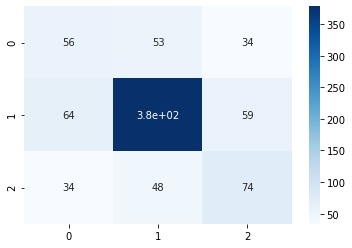

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(td_actual, td_predict)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
class_weights = {0: 1, 1: 1, 2: 1}
# calculate precision, recall, and F1 score
precision = precision_score(td_actual, td_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])
recall = recall_score(td_actual, td_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])
f1 = f1_score(td_actual, td_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

Precision:  0.6456086470066131
Recall:  0.635
F1 Score:  0.6398643954657887
Accuracy:  0.7783882783882784


## TC-LSTM 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TCLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TCLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # Concatenate output from both LSTMs
    
    def forward(self, x1,x2):
        lstm_out1, _ = self.lstm1(x1)
        lstm_out2, _ = self.lstm2(x2)
        lstm_out = torch.cat((lstm_out1[:, -1, :], lstm_out2[:, -1, :]), dim=1)  # Concatenate output from both LSTMs
        out = self.fc(lstm_out)
        return out
#_______________________________________________________________________________________________________________________________
input_size = 1636
hidden_size = 200
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 1

# Initialize the model and optimizer
tcmodel = TCLSTMClassifier(input_size, hidden_size, num_classes)
def test_tclstm(x1_new,x2_new):
    # Initialize the model with the same parameters as before
    tcmodel = TCLSTMClassifier(input_size, hidden_size, num_classes)

    # Load the saved state dictionary into the model
    tcmodel.load_state_dict(torch.load('tc-lstm.pt'))

    # Set the model to evaluation mode
    tcmodel.eval()
    # make a forward pass through the model to obtain the predicted output
    with torch.no_grad():
        predicted_output = tcmodel(torch.FloatTensor(x1_new).unsqueeze(0), torch.FloatTensor(x2_new).unsqueeze(0))

    # get the predicted class index (the class with the highest score)
    predicted_class = torch.argmax(predicted_output, dim=1).item()
    return predicted_class
#_______________________________________________________________________________________________________________________________________
def ind(sentence,aspect_term):
    sentence = splitSentence(sentence)
    aspect_term = splitSentence(aspect_term)
    try:
        start_index = sentence.index(aspect_term[0])
        end_index = start_index + len(aspect_term) - 1
    except ValueError:
        start_index = len(sentence) - 1
        end_index = start_index -1
    return [start_index,end_index]
#________________________________________________________________________________________________________________________________________
def create_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        ten1 = indomain_vector(sentence)
        ten2 = bert_to_token(sentence).detach()
        vec = torch.cat([ten1, ten2], dim=1).numpy()
        embeddings.append(vec)

    embeddings_array = np.array(embeddings)
    return torch.from_numpy(embeddings_array)
#_________________________________________________________________________________________________________________________________
def predict_tclstm(sentence,aspect_term):
    a = splitSentence(aspect_term)
    s = 0
    count = 0
    for j in a:
        s =  s + bert_to_token(j)
        count = count + 1
    embeddings = create_embeddings([sentence])
    tensor1 = torch.tensor(embeddings[0])
    tensor2 = s/count

    tensor2_repeated = tensor2.repeat(tensor1.shape[0], 1)
    tensor3 = torch.cat([tensor1, tensor2_repeated], dim=1)
    s2 = tensor3.detach().numpy()
    answer = []
    indices = ind(sentence,aspect_term)
    i1 = indices[0]
    j1 = indices[1]
    answer.append(s2[:i1+1])
    answer.append(s2[j1-1:])
    p = test_tclstm(answer[0],answer[1])
    return p

tc_actual = []
tc_predict = []
count = 0
for i in range(2800,3600):
    p = predict_tclstm(df['Sentence'][i] , df['Aspect Term'][i])
    tc_predict.append(p)
    tc_actual.append(df['polarity'][i])
        

<ipython-input-5-1c5b0a9fae71>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(embeddings[0])


#### CONFUSION MATRIX(TC-LSTM) and scores 

True Positives (TP):  381
True Negatives (TN):  44
False Positives (FP):  73
False Negatives (FN):  48


<AxesSubplot:>

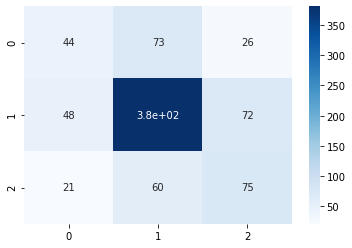

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(tc_actual, tc_predict)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")

In [ ]:

#_____________________________________________________________________________________________________________________________________
from sklearn.metrics import precision_score, recall_score, f1_score
class_weights = {0: 1, 1: 1.58, 2: 1}
# calculate precision, recall, and F1 score
precision = precision_score(tc_actual, tc_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])
recall = recall_score(tc_actual, tc_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])
f1 = f1_score(tc_actual, tc_predict,average='weighted',sample_weight=[class_weights[label] for label in tc_actual])

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

Precision:  0.6854078047630807
Recall:  0.6610977644922857
F1 Score:  0.6709713628793061
Accuracy:  0.7783882783882784


### Finetuning BERT 

In [ ]:
import gensim.downloader as api

# Download the pre-trained Word2Vec model from Google
w2v_model = api.load('word2vec-google-news-300')

# Define the function to split sentences into words/tokens using Word2Vec
import gensim.downloader as api

# Download the pre-trained Word2Vec model from Google
w2v_model = api.load('word2vec-google-news-300')

# Define the function to split sentences into words/tokens using Word2Vec
def split_sentence(sentence):
    words = []
    for word in splitSentence(sentence):
        if word in w2v_model:
            words.append(word)
    return words

def word2vec(sentence):
    words = splitSentence(sentence)

    # Get the word vectors for the words in the sentence
    vectors = [w2v_model[word] for word in words]
    return words,vectors


In [ ]:

import torch
from transformers import BertTokenizer, BertForSequenceClassification , AutoTokenizer , AutoModelForSequenceClassification

# Load the pre-trained BERT model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)




# Define your training data
sentences = list(df['Sentence'][:2800])
aspect_terms = list(df['Aspect Term'][:2800])
labels = list(df['polarity'][:2800])
# Tokenize the sentences and aspect terms
inputs = tokenizer(sentences, aspect_terms, padding=True, truncation=True, max_length=90, return_tensors='pt')


# Create a PyTorch Dataset
dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], torch.tensor(labels))

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
num_epochs=5
batch_size = 32
for epoch in range(num_epochs):
    i = 0
    for batch in torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True):
        input_ids, attention_mask, token_type_ids, label_ids = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=label_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        i = i + 1
    print("num_epochs = ",num_epochs,"and loss=",loss.item())
        



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

num_epochs =  5 and loss= 0.6676302552223206
num_epochs =  5 and loss= 0.6887586116790771
num_epochs =  5 and loss= 0.3197222948074341
num_epochs =  5 and loss= 0.32158613204956055
num_epochs =  5 and loss= 0.4464018940925598


In [ ]:
torch.save(model.state_dict(), 'bert-finetune.pt')

In [ ]:

# Use the model to predict the sentiment polarity for new data
new_sentences = list(df['Sentence'][2800:])
new_aspect_terms = list(df['Aspect Term'][2800:])
model.eval()
with torch.no_grad():
    inputs = tokenizer(new_sentences, new_aspect_terms, padding=True, truncation=True, max_length=128, return_tensors='pt')
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], token_type_ids=inputs['token_type_ids'])
    predictions = torch.argmax(outputs.logits, dim=-1)
   

In [ ]:
c = 0
actual = list(df['polarity'][2800:])


### Result discussion about BERT finetuning 

True Positives (TP):  471
True Negatives (TN):  65
False Positives (FP):  66
False Negatives (FN):  22


<AxesSubplot:>

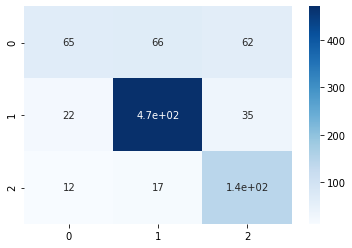

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(actual, predictions)

# extract TP, TN, FP, FN
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# calculate PP and PN
PP = TP + FN
PN = TN + FP

# print results
print("True Positives (TP): ", TP)
print("True Negatives (TN): ", TN)
print("False Positives (FP): ", FP)
print("False Negatives (FN): ", FN)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap="Blues")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
class_weights = {0: 1, 1: 0.58, 2: 1}
precision = precision_score(l, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])
recall = recall_score(l, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])
f1 = f1_score(l, predictions,average='weighted',sample_weight=[class_weights[label] for label in actual])

# print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", accuracy)

Precision:  0.7207690431543124
Recall:  0.716852392586856
F1 Score:  0.692946108287391
Accuracy:  0.8589743589743589
